Below is the skeleton code to make the tic tac toe game.

In [41]:
import random
import math
import numpy as np

# Define winning combinations
winning_combos = [
    (0, 1, 2),  # Rows
    (3, 4, 5),
    (6, 7, 8),
    (0, 3, 6),  # Columns
    (1, 4, 7),
    (2, 5, 8),
    (0, 4, 8),  # Diagonals
    (2, 4, 6)
]

def check_winner(board, player):
    """Check if the given player has won."""
    for combo in winning_combos:
        if all(board[i] == player for i in combo):
            return True
    return False

def check_draw(board):
    """Check if the game is a draw."""
    return ' ' not in board

def available_moves(board):
    """Return a list of available moves."""
    return [i for i, spot in enumerate(board) if spot == ' ']

def print_board(board):
    """Print the current board state."""
    print(f"{board[0]} | {board[1]} | {board[2]}")
    print("--+---+--")
    print(f"{board[3]} | {board[4]} | {board[5]}")
    print("--+---+--")
    print(f"{board[6]} | {board[7]} | {board[8]}")

In [42]:
import random

# Utility functions
def available_moves(board):
    """Return a list of available moves."""
    return [i for i, cell in enumerate(board) if cell == ' ']

def check_winner(board, player):
    """Check if the player has won the game."""
    winning_combinations = [
        [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
        [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
        [0, 4, 8], [2, 4, 6]              # Diagonals
    ]
    return any(all(board[pos] == player for pos in combo) for combo in winning_combinations)

def is_draw(board):
    """Check if the game is a draw."""
    return ' ' not in board and not (check_winner(board, 'X') or check_winner(board, 'O'))

def rotate_board(board):
    """Rotate the board 90 degrees clockwise."""
    return [
        board[6], board[3], board[0],
        board[7], board[4], board[1],
        board[8], board[5], board[2]
    ]

def reflect_board(board):
    """Reflect the board horizontally."""
    return [
        board[2], board[1], board[0],
        board[5], board[4], board[3],
        board[8], board[7], board[6]
    ]

def canonical_form(board):
    """Return the canonical form of a board."""
    transformations = []
    current_board = board
    for _ in range(4):  # Rotate 4 times
        transformations.append(tuple(current_board))
        current_board = rotate_board(current_board)
    current_board = reflect_board(board)
    for _ in range(4):  # Reflect and rotate 4 times
        transformations.append(tuple(current_board))
        current_board = rotate_board(current_board)
    return min(transformations)

# Updated functions with compression
state_statistics = {}
nsim = 1000

def update_state_statistics(state, winner):
    """Update the statistics for a given canonical game state."""
    state = canonical_form(state)
    if state not in state_statistics:
        state_statistics[state] = [0, 0, 0, 0]  # [games_played, x_wins, o_wins, draws]
    
    state_statistics[state][0] += 1  # Increment games played
    
    if winner == 'X':
        state_statistics[state][1] += 1  # Increment X wins
    elif winner == 'O':
        state_statistics[state][2] += 1  # Increment O wins
    elif winner == 'draw':
        state_statistics[state][3] += 1  # Increment draws

def simulate_game(agent, verbose=False):
    """Simulate a single game and update state statistics."""
    board = [' '] * 9
    current_player = 'X'
    state_action_history = []
    
    while True:
        state = tuple(board)
        action = agent.choose_action(board, current_player)
        board[action] = current_player
        next_state = tuple(board)
        state_action_history.append((state, action, current_player))

        if check_winner(board, current_player):
            winner = current_player
            for state, action, player in state_action_history:
                update_state_statistics(state, winner=winner)
            break
        elif is_draw(board):
            for state, action, player in state_action_history:
                update_state_statistics(state, winner='draw')
            break
        else:
            current_player = 'O' if current_player == 'X' else 'X'
    
    if verbose:
        print_board(board)

def train_agent(agent, episodes):
    """Train the agent by simulating games and updating state statistics."""
    for episode in range(episodes):
        simulate_game(agent)
    print(f"Training complete after {episodes} episodes.")

def calculate_win_draw_rates():
    """Calculate the win and draw rates for all encountered game states."""
    win_draw_rates = {}
    for state, stats in state_statistics.items():
        games_played, x_wins, o_wins, draws = stats
        if games_played > 0:
            x_win_rate = x_wins / games_played
            o_win_rate = o_wins / games_played
            draw_rate = draws / games_played
            win_draw_rates[state] = {
                'X_win_rate': x_win_rate,
                'O_win_rate': o_win_rate,
                'draw_rate': draw_rate
            }
    return win_draw_rates

# Example of an agent with random actions (you can replace this with your agent logic)
class RandomAgent:
    def choose_action(self, board, player):
        """Randomly choose an available action."""
        return random.choice(available_moves(board))

# Train the agent and collect state statistics
agent = RandomAgent()
train_agent(agent, episodes=nsim)

# Calculate win and draw rates from the simulations
win_draw_rates = calculate_win_draw_rates()

# Display some sample win and draw rates (you can analyze them further or store them)
for state, rates in list(win_draw_rates.items())[:10]:  # Display first 10 states and their win/draw rates
    print(f"State: {state}, X win rate: {rates['X_win_rate']:.2f}, O win rate: {rates['O_win_rate']:.2f}, Draw rate: {rates['draw_rate']:.2f}")


Training complete after 1000 episodes.
State: (' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), X win rate: 0.60, O win rate: 0.27, Draw rate: 0.13
State: (' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'X'), X win rate: 0.63, O win rate: 0.23, Draw rate: 0.14
State: (' ', ' ', ' ', ' ', ' ', 'O', 'X', ' ', ' '), X win rate: 0.64, O win rate: 0.30, Draw rate: 0.06
State: (' ', ' ', 'X', ' ', ' ', ' ', 'X', 'O', ' '), X win rate: 0.79, O win rate: 0.17, Draw rate: 0.03
State: (' ', ' ', 'X', 'O', ' ', ' ', 'X', ' ', 'O'), X win rate: 0.82, O win rate: 0.18, Draw rate: 0.00
State: (' ', 'O', 'X', 'X', ' ', ' ', 'X', ' ', 'O'), X win rate: 0.62, O win rate: 0.38, Draw rate: 0.00
State: (' ', 'O', 'X', 'X', 'O', ' ', 'X', ' ', 'O'), X win rate: 0.67, O win rate: 0.33, Draw rate: 0.00
State: (' ', 'O', 'X', 'X', 'O', ' ', 'X', 'X', 'O'), X win rate: 0.67, O win rate: 0.33, Draw rate: 0.00
State: (' ', ' ', ' ', ' ', ' ', ' ', ' ', 'X', ' '), X win rate: 0.56, O win rate: 0.32, Draw rate: 0.11
State: 

Making our dataset of randomly played games

In [43]:
state_statistics = {}
nsim = 1000

def update_state_statistics(state, winner):
    """Update the statistics for a given game state."""
    if state not in state_statistics:
        state_statistics[state] = [0, 0, 0, 0]  # [games_played, x_wins, o_wins, draws]
    
    state_statistics[state][0] += 1  # Increment games played
    
    if winner == 'X':
        state_statistics[state][1] += 1  # Increment X wins
    elif winner == 'O':
        state_statistics[state][2] += 1  # Increment O wins
    elif winner == 'draw':
        state_statistics[state][3] += 1  # Increment draws

def simulate_game(agent, verbose=False):
    """Simulate a single game and update state statistics."""
    board = [' '] * 9
    current_player = 'X'
    state_action_history = []
    
    while True:
        state = tuple(board)
        action = agent.choose_action(board, current_player)
        board[action] = current_player
        next_state = tuple(board)
        state_action_history.append((state, action, current_player))

        if check_winner(board, current_player):
            winner = current_player
            for state, action, player in state_action_history:
                update_state_statistics(state, winner=winner)
            break
        elif is_draw(board):
            for state, action, player in state_action_history:
                update_state_statistics(state, winner='draw')
            break
        else:
            current_player = 'O' if current_player == 'X' else 'X'
    
    if verbose:
        print_board(board)

def train_agent(agent, episodes):
    """Train the agent by simulating games and updating state statistics."""
    for episode in range(episodes):
        simulate_game(agent)
    print(f"Training complete after {episodes} episodes.")

def calculate_win_draw_rates():
    """Calculate the win and draw rates for all encountered game states."""
    win_draw_rates = {}
    for state, stats in state_statistics.items():
        games_played, x_wins, o_wins, draws = stats
        if games_played > 0:
            x_win_rate = x_wins / games_played
            o_win_rate = o_wins / games_played
            draw_rate = draws / games_played
            win_draw_rates[state] = {
                'X_win_rate': x_win_rate,
                'O_win_rate': o_win_rate,
                'draw_rate': draw_rate
            }
    return win_draw_rates

# Example of an agent with random actions (you can replace this with your agent logic)
class RandomAgent:
    def choose_action(self, board, player):
        """Randomly choose an available action."""
        return random.choice(available_moves(board))

# Train the agent and collect state statistics
agent = RandomAgent()
train_agent(agent, episodes=nsim)

# Calculate win and draw rates from the simulations
win_draw_rates = calculate_win_draw_rates()

# Display some sample win and draw rates (you can analyze them further or store them)
for state, rates in list(win_draw_rates.items())[:10]:  # Display first 10 states and their win/draw rates
    print(f"State: {state}, X win rate: {rates['X_win_rate']:.2f}, O win rate: {rates['O_win_rate']:.2f}, Draw rate: {rates['draw_rate']:.2f}")


Training complete after 1000 episodes.
State: (' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), X win rate: 0.58, O win rate: 0.29, Draw rate: 0.13
State: (' ', ' ', ' ', ' ', ' ', ' ', 'X', ' ', ' '), X win rate: 0.57, O win rate: 0.29, Draw rate: 0.14
State: (' ', ' ', ' ', 'O', ' ', ' ', 'X', ' ', ' '), X win rate: 0.69, O win rate: 0.19, Draw rate: 0.12
State: (' ', 'X', ' ', 'O', ' ', ' ', 'X', ' ', ' '), X win rate: 0.20, O win rate: 0.20, Draw rate: 0.60
State: (' ', 'X', ' ', 'O', 'O', ' ', 'X', ' ', ' '), X win rate: 0.00, O win rate: 1.00, Draw rate: 0.00
State: (' ', 'X', 'X', 'O', 'O', ' ', 'X', ' ', ' '), X win rate: 0.00, O win rate: 1.00, Draw rate: 0.00
State: ('O', 'X', 'X', 'O', 'O', ' ', 'X', ' ', ' '), X win rate: 0.00, O win rate: 1.00, Draw rate: 0.00
State: ('O', 'X', 'X', 'O', 'O', 'X', 'X', ' ', ' '), X win rate: 0.00, O win rate: 1.00, Draw rate: 0.00
State: ('X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), X win rate: 0.61, O win rate: 0.24, Draw rate: 0.15
State: 

def combined_heuristic(state, action, current_player, next_player):
    """Calculate the combined value of a move based on win/loss rates."""
    # Get the resulting state after the action is taken
    board = list(state)
    board[action] = current_player
    next_state = tuple(board)
    
    # Get win and loss rates for current player and opponent
    win_rate_current = win_draw_rates.get(next_state, {}).get(f'{current_player}_win_rate', 0)
    win_rate_opponent = win_draw_rates.get(next_state, {}).get(f'{next_player}_win_rate', 0)
    
    # You can also consider draw rate if needed
    draw_rate = win_draw_rates.get(next_state, {}).get('draw_rate', 0)
    
    # Weights for win, opponent win (loss prevention), and draw
    alpha = 1.0  # Weight for maximizing your win
    beta = 0.1  # Weight for minimizing opponent win
    gamma = 0.1  # Weight for considering draws (tune as needed)
    
    # Calculate the combined heuristic value
    value = alpha * win_rate_current - beta * win_rate_opponent + gamma * draw_rate
    return value

def choose_best_action(board, current_player, next_player):
    """Choose the best action based on combined win/loss minimization strategy."""
    available_actions = available_moves(board)
    best_value = -float('inf')
    best_action = None
    
    for action in available_actions:
        value = combined_heuristic(tuple(board), action, current_player, next_player)
        if value > best_value:
            best_value = value
            best_action = action
    
    return best_action

# Example usage in a game
class SmartAgent:
    def choose_action(self, board, player):
        """Choose an action based on the combined heuristic strategy."""
        next_player = 'O' if player == 'X' else 'X'
        return choose_best_action(board, player, next_player)

# Train the smart agent
smart_agent = SmartAgent()
train_agent(smart_agent, episodes=nsim)

# Simulate a game
simulate_game(smart_agent, verbose=True)

import math
import random

def print_board(board):
    print(" ")
    for i in range(3):
        print(" " + " | ".join(board[i]))
        if i < 2:
            print("---|---|---")
    print(" ")

def check_win(board, player):
    for i in range(3):
        if all([cell == player for cell in board[i]]):
            return True
        if all([board[j][i] == player for j in range(3)]):
            return True
    if all([board[i][i] == player for i in range(3)]) or all([board[i][2-i] == player for i in range(3)]):
        return True
    return False

def check_draw(board):
    return all([cell != " " for row in board for cell in row])

def evaluate(board):
    if check_win(board, 'O'):
        return 1
    elif check_win(board, 'X'):
        return -1
    else:
        return 0

def minimax(board, depth, alpha, beta, is_maximizing):
    score = evaluate(board)
    if score == 1 or score == -1 or check_draw(board):
        return score

    if is_maximizing:
        best_score = -math.inf
        for i in range(3):
            for j in range(3):
                if board[i][j] == " ":
                    board[i][j] = 'O'
                    best_score = max(best_score, minimax(board, depth + 1, alpha, beta, False))
                    board[i][j] = " "
                    alpha = max(alpha, best_score)
                    if alpha >= beta:  # Pruning condition for the maximizing player
                        break
            if alpha >= beta:  # Pruning condition for the maximizing player
                break
        return best_score
    else:
        best_score = math.inf
        for i in range(3):
            for j in range(3):
                if board[i][j] == " ":
                    board[i][j] = 'X'
                    best_score = min(best_score, minimax(board, depth + 1, alpha, beta, True))
                    board[i][j] = " "
                    beta = min(beta, best_score)
                    if beta <= alpha:  # Pruning condition for the minimizing player
                        break
            if beta <= alpha:  # Pruning condition for the maximizing player
                break
        return best_score


def find_best_move(board):
    best_score = -math.inf
    best_move = (-1, -1)
    alpha = -math.inf
    beta = math.inf
    for i in range(3):
        for j in range(3):
            if board[i][j] == " ":
                board[i][j] = 'O'
                move_score = minimax(board, 0, alpha, beta, False)
                board[i][j] = " "
                if move_score >= best_score:
                    best_score = move_score
                    best_move = (i, j)
    return best_move

def main():
    board = [[" " for _ in range(3)] for _ in range(3)]
    print("Let's play Tic-Tac-Toe!")
    z = input("Do you want to start Y/N : ")
    if z.lower() != 'y':
        while True:
            ai_x = random.randint(0, 2)
            ai_y = random.randint(0, 2)
            if board[ai_x][ai_y] == " ":
                board[ai_x][ai_y] = 'O' 
                break
        print("AI starts!")
        print_board(board)

    while True:
        x, y = map(int, input("Enter coordinates for X (row column): ").strip().split())
        board[x][y] = 'X'
        print_board(board)
        if check_win(board, 'X'):
            print("You win!")
            break
        if check_draw(board):
            print("It's a draw!")
            break
        print("AI is making a move...")

        ai_x, ai_y = find_best_move(board)
        board[ai_x][ai_y] = 'O'
        print_board(board)
        if check_win(board, 'O'):
            print("You lose!")
            break
        if check_draw(board):
            print("It's a draw!")
            break

if __name__ == '__main__':
    main()

In [ ]:
def play_game():
    """Allow a human player to play against the trained SmartAgent."""
    board = [' '] * 9
    human_player = input("Choose your player (X or O): ").upper()
    
    if human_player not in ['X', 'O']:
        print("Invalid choice. Defaulting to X.")
        human_player = 'X'
    
    ai_player = 'O' if human_player == 'X' else 'X'
    current_player = 'X'  # X always starts the game
    smart_agent = SmartAgent()

    print_board(board)

    while True:
        if current_player == human_player:
            # Human's turn
            available = available_moves(board)
            move = None
            while move not in available:
                try:
                    move = int(input(f"Your move (choose from {available}): "))
                    if move not in available:
                        print("Invalid move. Try again.")
                except ValueError:
                    print("Please enter a valid number.")
            board[move] = human_player
        else:
            # Smart agent's turn
            print(f"SmartAgent ({ai_player}) is thinking...")
            move = smart_agent.choose_action(board, ai_player)
            board[move] = ai_player
            print(f"SmartAgent ({ai_player}) played at position {move}")

        print_board(board)

        # Check for winner or draw
        if check_winner(board, current_player):
            print(f"Player {current_player} wins!")
            break
        elif is_draw(board):
            print("It's a draw!")
            break

        # Switch players
        current_player = 'O' if current_player == 'X' else 'X'

# Train the SmartAgent with 10,000 games
agent = SmartAgent()
train_agent(agent, episodes=10000)

# Now play against the trained agent
play_game()

Results after 1000 games:
Perfect bot wins: 811
Random bot wins: 0
Draws: 189


KeyboardInterrupt: 

In [59]:
import random
import math
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Constants
nsim = 80000  # Number of games to simulate for Random Forest training data
comp_games = 10  # Number of games to simulate for Random Forest bot vs Perfect bot


# Generate training data from random games
def generate_training_data(num_games):
    def simulate_random_game():
        board = [" "] * 9
        current_player = 'X'
        game_data = []

        while True:
            move = random.choice([i for i, cell in enumerate(board) if cell == " "])
            board[move] = current_player
            game_data.append((board[:], current_player))

            if check_winner(board, current_player):
                return game_data, current_player
            if check_draw(board):
                return game_data, 'draw'

            current_player = 'O' if current_player == 'X' else 'X'

    data, labels = [], []
    for _ in range(num_games):
        game_data, result = simulate_random_game()
        for state, player in game_data:
            features = [1 if cell == 'X' else -1 if cell == 'O' else 0 for cell in state]
            label = 1 if result == player else -1 if result != 'draw' else 0
            data.append(features)
            labels.append(label)

    return np.array(data), np.array(labels)

# Train Random Forest bot
def train_random_forest_bot(num_games):
    data, labels = generate_training_data(num_games)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest model accuracy: {accuracy:.2f}")
    
    return rf_model

# Random Forest Bot
class RandomForestBot:
    def __init__(self, model):
        self.model = model
    
    def choose_action(self, board, current_player):
        features = []
        for move in [i for i, cell in enumerate(board) if cell == " "]:
            temp_board = board[:]
            temp_board[move] = current_player
            features.append([1 if cell == 'X' else -1 if cell == 'O' else 0 for cell in temp_board])
        
        predictions = self.model.predict(features)
        best_move = [i for i, cell in enumerate(board) if cell == " "][np.argmax(predictions)]
        return best_move

# Perfect Bot Logic (Minimax)
def evaluate(board):
    if check_winner(board, 'O'):
        return 1
    elif check_winner(board, 'X'):
        return -1
    else:
        return 0

def minimax(board, depth, alpha, beta, is_maximizing):
    score = evaluate(board)
    if score == 1 or score == -1 or check_draw(board):
        return score

    if is_maximizing:
        best_score = -math.inf
        for i in range(9):
            if board[i] == " ":
                board[i] = 'O'
                best_score = max(best_score, minimax(board, depth + 1, alpha, beta, False))
                board[i] = " "
                alpha = max(alpha, best_score)
                if alpha >= beta:
                    break
        return best_score
    else:
        best_score = math.inf
        for i in range(9):
            if board[i] == " ":
                board[i] = 'X'
                best_score = min(best_score, minimax(board, depth + 1, alpha, beta, True))
                board[i] = " "
                beta = min(beta, best_score)
                if beta <= alpha:
                    break
        return best_score

def find_best_move(board):
    best_score = -math.inf
    best_move = -1
    alpha = -math.inf
    beta = math.inf
    for i in range(9):
        if board[i] == " ":
            board[i] = 'O'
            move_score = minimax(board, 0, alpha, beta, False)
            board[i] = " "
            if move_score > best_score:
                best_score = move_score
                best_move = i
    return best_move

# Play Random Forest Bot vs Perfect Bot
def play_game_rf_vs_perfect(rf_bot):
    board = [" "] * 9
    current_player = 'X'  # Random Forest bot starts
    
    while True:
        if current_player == 'X':
            move = rf_bot.choose_action(board, current_player)
        else:
            move = find_best_move(board)  # Perfect bot logic
        
        board[move] = current_player

        if check_winner(board, current_player):
            return current_player
        if check_draw(board):
            return 'draw'
        
        current_player = 'O' if current_player == 'X' else 'X'

def simulate_rf_vs_perfect(rf_bot, num_games):
    results = {'rf_wins': 0, 'perfect_wins': 0, 'draws': 0}
    
    for _ in range(num_games):
        result = play_game_rf_vs_perfect(rf_bot)
        if result == 'X':
            results['rf_wins'] += 1
        elif result == 'O':
            results['perfect_wins'] += 1
        elif result == 'draw':
            results['draws'] += 1
    
    return results

# Utility functions
def check_winner(board, player):
    winning_combinations = [
        [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
        [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
        [0, 4, 8], [2, 4, 6]              # Diagonals
    ]
    return any(all(board[pos] == player for pos in combo) for combo in winning_combinations)

def check_draw(board):
    return ' ' not in board

# Main Execution
if __name__ == '__main__':
    # Train the Random Forest bot
    rf_model = train_random_forest_bot(nsim)
    rf_bot = RandomForestBot(rf_model)
    
    # Simulate games against the Perfect bot
    results = simulate_rf_vs_perfect(rf_bot, comp_games)
    
    print(f"Results after {comp_games} games:")
    print(f"Random Forest bot wins: {results['rf_wins']}")
    print(f"Perfect bot wins: {results['perfect_wins']}")
    print(f"Draws: {results['draws']}")


Random Forest model accuracy: 0.68
Results after 10 games:
Random Forest bot wins: 0
Perfect bot wins: 10
Draws: 0


In [76]:
import pandas as pd

# Function to create multiple bots, test them, and summarize results
def create_and_test_bots(nsim_levels, bots_per_level, comp_games):
    results = []
    for nsim in nsim_levels:
        for bot_id in range(1, bots_per_level + 1):
            # Train a Random Forest bot on a unique dataset
            rf_model = train_random_forest_bot(nsim)
            rf_bot = RandomForestBot(rf_model)

            # Simulate games against the Perfect bot
            test_results = simulate_rf_vs_perfect(rf_bot, comp_games)

            # Summarize results for this bot
            results.append({
                'nsim': nsim,
                'bot_id': f"Bot_{nsim}_{bot_id}",
                'rf_wins': test_results['rf_wins'],
                'perfect_wins': test_results['perfect_wins'],
                'draws': test_results['draws'],
                'total_games': comp_games
            })

    # Create a DataFrame from results
    df_summary = pd.DataFrame(results)
    return df_summary

# Execute the bot creation and testing
nsim_levels = [10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000,
            50000, 52000, 54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000, 72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000, 90000]

bots_per_level = 10
comp_games = 1

df_summary = create_and_test_bots(nsim_levels, bots_per_level, comp_games)

# Display the DataFrame with summaries
print(df_summary)


Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.66
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.67
Random Forest model accuracy: 0.66
Random Forest model 

Index(['nsim', 'bot_id', 'rf_wins', 'perfect_wins', 'draws', 'total_games'], dtype='object')
nsim
10000     5
12000     4
14000     4
16000     4
18000     3
20000     4
22000     6
24000     6
26000     7
28000     8
30000     7
32000     4
34000     8
36000     9
38000     5
40000     6
42000     8
44000     9
46000     6
48000     7
50000     7
52000     7
54000     7
56000     7
58000     9
60000     7
62000     7
64000     6
66000     8
68000     6
70000     7
72000     7
74000     9
76000    10
78000     9
80000     8
82000     8
84000     9
86000     9
88000     9
90000     8
Name: draws, dtype: int64


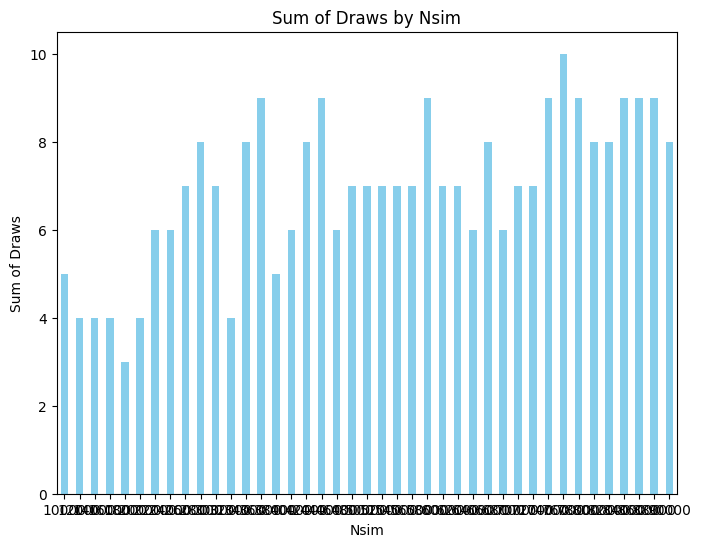

In [83]:
import matplotlib.pyplot as plt

print(df_summary.columns)
# Group the data by `nsim` and calculate the sum of `draws` for each level
draws_by_nsim = df_summary.groupby('nsim')['draws'].sum()
print(draws_by_nsim)

draws_by_nsim.plot(kind='bar', color='skyblue', figsize=(8, 6))

# Customize the chart
plt.xlabel('Nsim')
plt.ylabel('Sum of Draws')
plt.title('Sum of Draws by Nsim')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability

# Show the chart
plt.show()

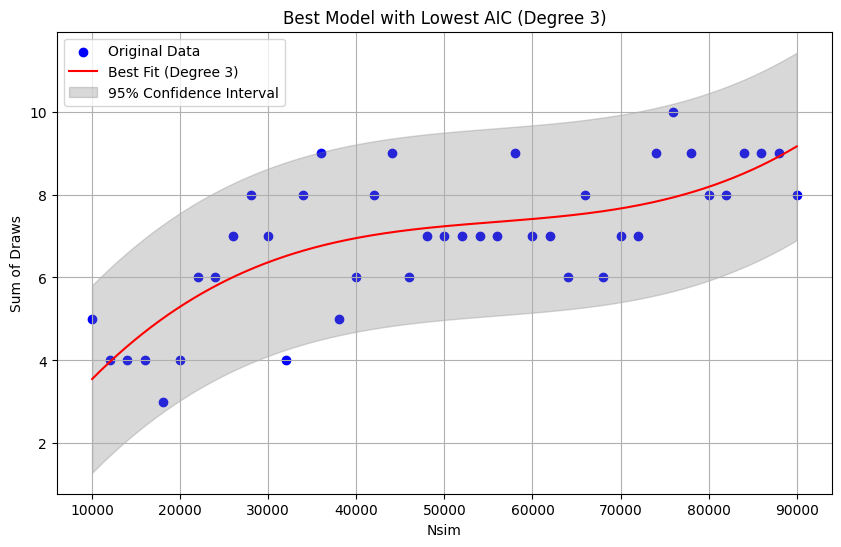

AIC Values and Coefficients for Models:

Degree 1:
AIC = 20.91
Coefficients (Betas): [5.14808362e-05 4.35278746e+00]

Degree 2:
AIC = 20.80
Coefficients (Betas): [-5.49684292e-10  1.06449265e-04  3.28639993e+00]

Degree 3:
AIC = 19.65
Coefficients (Betas): [ 3.14148092e-14 -5.26190568e-09  3.10419339e-04  9.41598569e-01]


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Example data: Replace with your DataFrame values
nsim_values = df_summary['nsim'].unique()
draws_sum = df_summary.groupby('nsim')['draws'].sum()

# Function to calculate AIC
def calculate_aic(y_true, y_pred, num_params):
    residual_sum_of_squares = np.sum((y_true - y_pred) ** 2)
    n = len(y_true)
    aic = n * np.log(residual_sum_of_squares / n) + 2 * num_params
    return aic

# Fit models with linear, quadratic, and cubic terms
models = {}
aic_values = {}
coefficients_list = {}

for degree in [1, 2, 3]:  # Linear, Quadratic, Cubic
    coefficients = np.polyfit(nsim_values, draws_sum, degree)
    poly_fit = np.poly1d(coefficients)
    y_pred = poly_fit(nsim_values)
    
    # Save coefficients
    coefficients_list[degree] = coefficients
    
    # Calculate AIC
    aic = calculate_aic(draws_sum, y_pred, degree + 1)  # degree+1 parameters include the intercept
    models[degree] = poly_fit
    aic_values[degree] = aic

# Find the model with the lowest AIC
best_degree = min(aic_values, key=aic_values.get)
best_model = models[best_degree]

# Generate x values for plotting the best fit line
x_fit = np.linspace(nsim_values.min(), nsim_values.max(), 500)
y_fit = best_model(x_fit)

# Calculate residuals and standard deviation
residuals = draws_sum - best_model(nsim_values)
std_dev = np.std(residuals)

# Calculate confidence intervals
ci_upper = y_fit + 1.96 * std_dev
ci_lower = y_fit - 1.96 * std_dev

# Plot the original data and the best fit line
plt.figure(figsize=(10, 6))
plt.scatter(nsim_values, draws_sum, color='blue', label='Original Data')
plt.plot(x_fit, y_fit, color='red', label=f'Best Fit (Degree {best_degree})')
plt.fill_between(x_fit, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% Confidence Interval')

# Customize the plot
plt.xlabel('Nsim')
plt.ylabel('Sum of Draws')
plt.title(f'Best Model with Lowest AIC (Degree {best_degree})')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display AIC values and coefficients
print("AIC Values and Coefficients for Models:")
for degree, aic in aic_values.items():
    print(f"\nDegree {degree}:")
    print(f"AIC = {aic:.2f}")
    print("Coefficients (Betas):", coefficients_list[degree])
